# Multi-SWAG

## Introduction

In this notebook, we will illustrate how to use Push to apply **Stochastic Weight Averaging Gaussian** (SWAG) [1] to perform BDL. SWAG approximates the posterior distribution of a BNN as a Normal distribution with mean and covariance estimated from gradient descent iterates during traditional training.

### Setting up the Dataset

We will use the sine wave dataset from the [introductory tutorial](https://lbai-push.readthedocs.io/en/latest/tutorials/01_Bayesian_Deep_Learning/bayesian_deep_learning.html):

$$
\begin{align}
    y & = sin(x) + \epsilon \\
    \epsilon & \sim \mathcal{N}(0, 0.05) \,.
\end{align}
$$

The code for `SineWithNoiseDataset` is contained in the module `bdl`.

In [1]:
import math
import matplotlib.pyplot as plt

# from bdl import SineWithNoiseDataset   # Import dataset
from experiments.nns.bdl import SineWithNoiseDataset


D = 1                                  # dimensions
N = 2048                               # number of points
train_begin_radians = -2 * math.pi     # left interval
train_end_radians = 2 * math.pi        # right interval

# Define the dataset as a PyTorch dataset
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.plot(dataset.xs, dataset.ys, c ='black')
plt.title('SineWithNoiseDataset')
plt.xlabel('Input X')
plt.ylabel('Target Y')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

ModuleNotFoundError: No module named 'bdl'

## Defining the Model

We will use the same NN architectures `MiniNN` and `BiggerNN` that we used in the [introductory tutorial](https://lbai-push.readthedocs.io/en/latest/tutorials/01_Bayesian_Deep_Learning/bayesian_deep_learning.html). The code for `MiniNN` and `BiggerNN` is contained in the module `bdl`.

In [ ]:
# Import modules 
from bdl import MiniNN, BiggerNN

## SWAG in Push

We will use the implementation of SWAG provided by Push. To apply SWAG, we first create a `MultiSWAG` object. **MultiSWAG** is an extension of SWAG to multiple particles which we will discuss soon.

In [ ]:
import push.bayes.swag
from push.bayes.swag import MultiSWAG

args = [
    4,    # number of layers
    1,    # input dimensions
    1,    # output dimensions
    64,   # hidden dimensions
]
mswag = MultiSWAG(BiggerNN, *args)

### Performing Bayesian Inference

The `MultiSWAG` class contains a `bayes_infer` method that we can use to perform Bayesian inference. At a high-level, the algorithm works as follows:
1. Train a given NN using a standard optimization method for a certain number of epochs (`pretrain_epochs`).
2. Continue to train a given NN using a standard optimization method, this time, keeping track of the first and second moments of the parameters at each gradient descent iterate (`swag_epochs`). The first and second moment information is used later on to estimate the mean and covariance of the Gaussian distribution used to approximate the posterior distribution.

In [ ]:
import torch
from torch.utils.data import DataLoader

# 1. Create dataloader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 2. Perform bayesian inference with SWAG
mswag.bayes_infer(
    dataloader,
    pretrain_epochs=75,
    swag_epochs=25,
    cov_mat_rank=20,
    num_models=1
)
swag = mswag

100%|██████████| 25/25 [00:01<00:00, 17.63it/s]


### Multiple SWAG (MultiSWAG)

Intuitively, SWAG performs averaging within a single basin of attraction since the NN is optimized for `pretrain_epochs` before using `swag_epochs` number of gradient descent iterates to estimate the mean and covariance of a Gaussian distribution which is unimodal. SWAG can be extended to Multiple SWAG (MultiSWAG) [2], similar to deep ensembles, which allows for averaging over multiple basins of attraction. We can use the capabilities of Push to easily extend SWAG to MultiSWAG by simply changing `num_models` to increase the number of particles contained within an instance of `MultiSWAG`.

#### Training Two SWAG Models

The `push.bayes.swag` provides a `train_mswag` function that creates a `MultiSWAG` instance and calls `bayes_infer` to perform Bayesian inference.

In [ ]:
# 1. Training parameters
swag_epochs = 25
pretrain_epochs = 75
cov_mat_rank = 20
loss_fn = torch.nn.MSELoss()

# 2. Perform MultiSWAG
two_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, *args,      # NN template
    num_devices=2,        # Set the number of devices to 2 for faster training
    num_models=2,         # 2 SWAG instances
    cov_mat_rank=20,      # Rank of covariance matrix (used during posterior predictive inference)
    mswag_state = {}
)

100%|██████████| 25/25 [00:01<00:00, 13.54it/s]


#### Training four and eight SWAG instances

Just like we did with deep ensembles, we can increase the number of particles. In this example, we choose 4 and 8 SWAG instances. Note that Push handles the scaling of particles across multi-GPU devices. MultiSWAG, like deep ensembles, does not require communication between SWAG instances as a more advanced BDL algorithm might require such as Stein Variational Gradient Descent (SVGD). As a reminder, each SWAG particle has concurrent execution semantics so it can execute independently of other SWAG instances. 

In [ ]:
four_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, *args,    # NN template
    num_devices=2,      # Set the number of devices to 2 for faster training
    num_models=4,       # 4 SWAG instances
    cov_mat_rank=20,    # Rank of covariance matrix (used during posterior predictive inference)   
    mswag_state={},
)

eight_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, *args,    # NN template
    num_devices=2,      # Set the number of devices to 2 for faster training
    num_models=8,       # 8 SWAG instances
    cov_mat_rank = 20,  # Rank of covariance matrix (used during posterior predictive inference)
    mswag_state={},
)

100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


## Posterior Predictive Inference

Now that we have successfully trained a few models with MultiSWAG, we can make predictions with the model. We create a test dataset first. 

### Test Data

Like we did in the [introductory tutorial](https://lbai-push.readthedocs.io/en/latest/tutorials/01_Bayesian_Deep_Learning/bayesian_deep_learning.html), we set up the test dataset now with the sine wave of $D = 1$ dimensions defined on the interval $(-8\pi, 8\pi)$ with $N = 2048$ data points to check the out-of-distribution predictions obtained by MultiSWAG.

In [ ]:
import numpy as np

test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi
oos_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
test_dataloader = DataLoader(oos_dataset, batch_size=64, shuffle=False)

### Making Predictions from the Posterior Predictive Distribution

After training (i.e., calling `bayes_infer`), the instance of `MultiSWAG` contains the **posterior predictive** distribution. In the case of MultiSWAG, the posterior predictive distribution is approximated as a mixture of Gaussians. To make predictions using the posterior predictive distribution, we can use the `posterior_pred` method. The `posterior_pred` method uses the empirical first and second moments of the gradient descent iterates to estimate the posterior distribution as the following multi-variate Gaussian distribution:

$$
\tilde{\theta} \sim \mathcal{N}(\bar{\theta}, \frac{1}{2} \bar{\theta} (\Sigma_\text{diag} + \Sigma_{\text{low-rank}}))
$$

1. $\bar{\theta}$ is the empirical first moment calculated during training.
2. $\bar{\theta^2}$ is the empirical second moment calculated during training.
3. $\Sigma_\text{diag} = \text{diag}(\bar{\theta^2} - \bar{\theta}^2)$ are derived from the empirical first and second moments calculated during training.
4. $\hat{D}$ is a quantity derived from the empirical first and second moments calculated during training.
    - $D$ is a matrix with columns $D_i = (\theta_i − \bar{\theta}_i)$ is a column vector where $\theta_i$ is the $i$-th parameter estimate and $\bar{\theta}_i$ is the running estimate of the parameter's mean obtained from the first $i$-samples.
    - $\hat{D}$ is the matrix that contains the last $K$ columns of $D$.
    - $\Sigma_{\text{low-rank}} = \frac{1}{K-1} \hat{D}\hat{D}^T$ is a low rank approximation of the empirical covariance.

In [ ]:
modes = ["mean", "median", "min", "max", "std"]
one_particle_outputs = swag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=modes, f_reg=True)
two_particle_outputs = two_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=modes, f_reg=True)
four_particle_outputs = four_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=modes, f_reg=True)
eight_particle_outputs = eight_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=modes, f_reg=True)

#### Plotting our results

We can use the following helper function to help us visualize the range of predictions made by MultiSWAG.

In [ ]:
def plot_results(dataset, outputs, title):
    xs = dataset.xs
    ys = dataset.ys

    plt.figure(figsize=(8, 6))
    pred_upper = outputs["mean"] + outputs["std"]
    pred_lower = outputs["mean"] - outputs["std"]
    plt.plot(xs, ys, c="black", label="Ground Truth")
    plt.plot(xs, outputs["mean"], color="blue", lw=2, label="Mean Prediction")
    plt.plot(xs, pred_upper, "-b", alpha=0.5, lw=1)
    plt.plot(xs, pred_lower, "-b", alpha=0.5, lw=1)
    plt.fill_between(xs.view(-1).numpy(), pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
    plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
    plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
    plt.xlim(test_begin_radians, test_end_radians)

    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Target (Y)')
    plt.legend()
    plt.show()

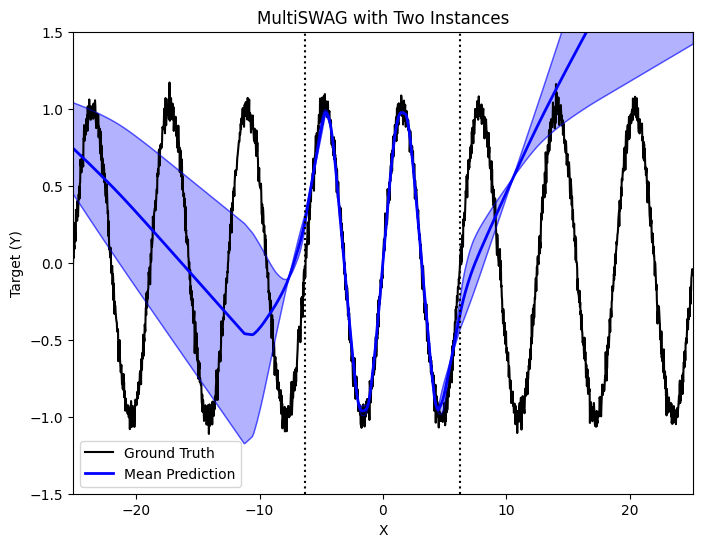

In [ ]:
plot_results(oos_dataset, two_particle_outputs, "MultiSWAG with Two Instances")

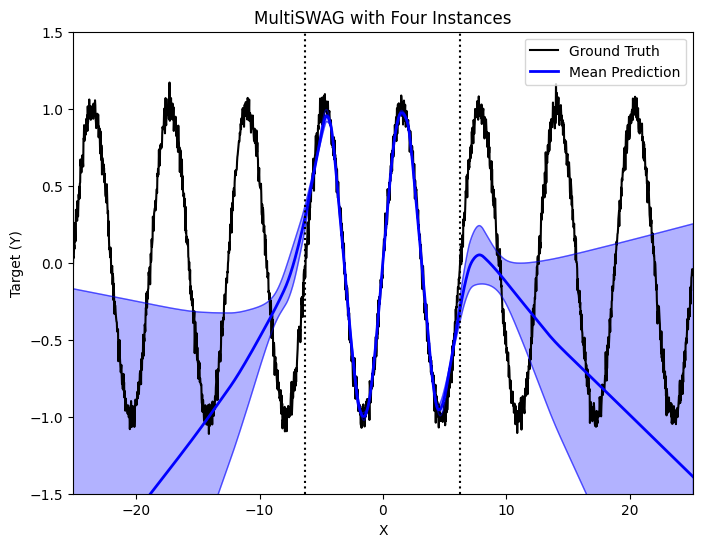

In [ ]:
plot_results(oos_dataset, four_particle_outputs, "MultiSWAG with Four Instances")

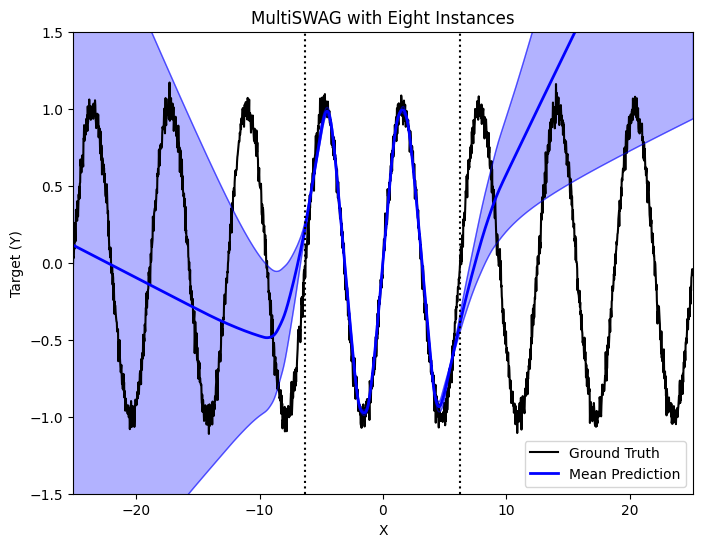

In [ ]:
plot_results(oos_dataset, eight_particle_outputs, "MultiSWAG with Eight Instances")

## References

[1] Wesley J. Maddox, Pavel Izmailov, Timur Garipov, Dmitry P. Vetrov, and Andrew Gordon Wilson. A simple baseline for bayesian uncertainty in deep learning. Advances in Neural Information Processing Systems, 32, 2019.

[2] Andrew Gordon Wilson and Pavel Izmailov. Bayesian deep learning and a probabilistic perspective of generalization. In Proceedings of the 34th International Conference on Neural Information Processing Systems, Neurips 2020.